# OIS Rate Data Processing Walkthrough

This notebook demonstrates the data processing pipeline for Overnight Indexed Swap (OIS) rate data, which is an essential component of our equity spot-futures arbitrage analysis project.


## Project Context: Equity Spot-Futures Arbitrage

Our project replicates a key component of the arbitrage analysis from Hazelkorn et al. (2021), focusing on the **equity spot-futures arbitrage spread**. This spread measures potential arbitrage opportunities between equity spot and futures markets.

In a perfectly efficient market, the no-arbitrage futures price follows:

$$F_{t,\tau} = S_t(1+r^f_{t,\tau}) - E^Q_t[D_{t,\tau}]$$

Where:
- $F_{t,\tau}$ is the futures price at time $t$ for maturity $t+\tau$
- $S_t$ is the spot price at time $t$
- $r^f_{t,\tau}$ is the risk-free rate
- $E^Q_t[D_{t,\tau}]$ is the expected dividend yield under risk-neutral measure

Due to the timing mismatch between equity spot markets (close at 4:00 PM EST) and futures markets (close at 4:15 PM EST), we focus on the **implied forward rate** derived from two futures contracts with different maturities $\tau_1 < \tau_2$:

$$1 + f^{\tau_1,\tau_2}_t = \frac{F_{t,\tau_2} + E^Q_t[D_{t,\tau_2}]}{F_{t,\tau_1} + E^Q_t[D_{t,\tau_1}]}$$

The equity spot-futures arbitrage spread is defined as:

$$ESF_t = f^{\tau_1,\tau_2}_t - OIS3M_t$$

where $OIS3M_t$ is the 3-month OIS rate, serving as our benchmark risk-free rate.

**In this notebook, we focus on the processing of the 3-month OIS rate data (OIS3M), which is a critical component for calculating the ESF spread.**

## Loading libraries and directories setup

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import logging
import sys
import os
from pathlib import Path
sys.path.insert(1, "./src")
from settings import config
import matplotlib.pyplot as plt

In [2]:
if 'src' in os.getcwd():
    os.chdir(os.path.pardir)
    print(os.getcwd())
else:
    print(os.getcwd())

C:\Users\Andik\OneDrive\Desktop\Chicago\Full_stack_QF\Equity_Spot_futures_arb


In [3]:
DATA_DIR = config("DATA_DIR")
TEMP_DIR = config("TEMP_DIR")
INPUT_DIR = config("INPUT_DIR")
PROCESSED_DIR = config("PROCESSED_DIR")
DATA_MANUAL = config("MANUAL_DATA_DIR")
START_DATE = config("START_DATE")
END_DATE = config("END_DATE")
OUTPUT_DIR = config("OUTPUT_DIR")

In [4]:
log_file = TEMP_DIR / f'ois_processing.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

In [5]:
# Required column mapping
OIS_TENORS = {
    "OIS_3M": "USSOC CMPN Curncy",   # 3 Month OIS Rate
}

In [6]:
INPUT_FILE = Path(INPUT_DIR) / "bloomberg_historical_data.parquet"
if not os.path.exists(INPUT_FILE):
    logger.warning("Primary input file not found, switching to cached data")
    INPUT_FILE = Path(DATA_MANUAL) / "bloomberg_historical_data.parquet"
    

2025-03-07 22:44:10,193 - WARNING - Primary input file not found, switching to cached data


In [7]:
logger.info(f"Loading OIS data from {INPUT_FILE}")

try:
    ois_df = pd.read_parquet(INPUT_FILE)
except Exception as e:
    logger.error(f"Error reading parquet file: {e}")
    raise

logger.info(f"Column levels: {ois_df.columns.names}")

2025-03-07 22:44:10,217 - INFO - Loading OIS data from C:\Users\Andik\OneDrive\Desktop\Chicago\Full_stack_QF\Equity_Spot_futures_arb\data_manual\bloomberg_historical_data.parquet
2025-03-07 22:44:10,302 - INFO - Column levels: [None, None]


## Data Inspection and Extraction

Let's examine the structure of the OIS data and extract the 3-month OIS rate:

In [8]:
# Ensure required OIS column is present
required_col = OIS_TENORS["OIS_3M"]
if (required_col, "PX_LAST") not in ois_df.columns:
    raise ValueError(f"Missing required OIS column: {required_col}")

# Select only the required 3-month OIS rate column
logger.info("Extracting 3-month OIS rate column")
ois_df = ois_df.loc[:, [(required_col, "PX_LAST")]]
ois_df.columns = ["OIS_3M"]  # Rename to a clean column name

# Display the first few rows
display(ois_df.head())

2025-03-07 22:44:10,309 - INFO - Extracting 3-month OIS rate column


,OIS_3M
2010-01-01,0.162
2010-01-04,0.162
2010-01-05,0.155
2010-01-06,0.146
2010-01-07,0.145


In [9]:
pd.set_option('display.max_columns', None)
ois_df.columns


Index(['OIS_3M'], dtype='object')

First thing to note about the data pulled from bloomberg is that it is structured in a multiindex format.

## Data Cleaning and Transformation

Now we'll clean the data and convert OIS rates from percentage to decimal format:

In [10]:
# Check for missing values before cleaning
missing_before = ois_df["OIS_3M"].isna().sum()
logger.info(f"Missing values before cleaning: {missing_before}")

# Convert OIS rates from percentage to decimal format
logger.info("Converting OIS_3M from percentage to decimal format")
ois_df["OIS_3M"] = ois_df["OIS_3M"] / 100

# Display the first few rows after conversion
display(ois_df.head())

# Drop rows with missing values
ois_df_clean = ois_df.dropna(subset=["OIS_3M"])
dropped_rows = len(ois_df) - len(ois_df_clean)
logger.info(f"Dropped {dropped_rows} rows with missing values")
ois_df = ois_df_clean

# Summary statistics
print("\n========== OIS Data Summary ==========")
print(f"Shape of dataset: {ois_df.shape} (rows, columns)")
print(f"Missing values after cleaning: {ois_df.isna().sum().iloc[0]}")
display(ois_df.describe())

2025-03-07 22:44:10,363 - INFO - Missing values before cleaning: 19
2025-03-07 22:44:10,367 - INFO - Converting OIS_3M from percentage to decimal format


,OIS_3M
2010-01-01,0.00162
2010-01-04,0.00162
2010-01-05,0.00155
2010-01-06,0.00146
2010-01-07,0.00145


2025-03-07 22:44:10,390 - INFO - Dropped 19 rows with missing values

========== OIS Data Summary ==========
Shape of dataset: (3894, 1) (rows, columns)
Missing values after cleaning: 0


,OIS_3M
count,3894.000000
mean,0.012734
std,0.017346
min,0.000430
25%,0.001070
50%,0.002130
75%,0.018882
max,0.054432


## Data Visualization

Let's visualize the 3-month OIS rate over time to understand its behavior:

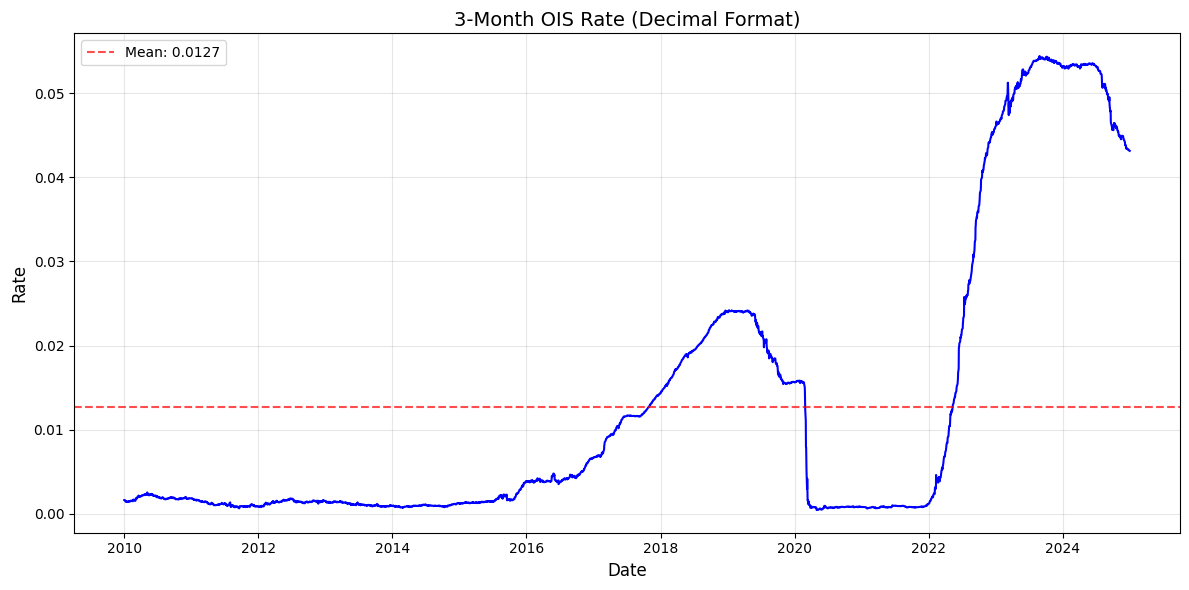


3-Month OIS Rate Summary Statistics:
Mean: 0.012734
Standard Deviation: 0.017346
Minimum: 0.000430
Maximum: 0.054432
Number of observations: 3894


In [11]:
# Ensure the index is a datetime for proper time series visualization
if not isinstance(ois_df.index, pd.DatetimeIndex):
    logger.warning("Converting index to datetime")
    ois_df.index = pd.to_datetime(ois_df.index)

# Plot the 3-month OIS rate over time
plt.figure(figsize=(12, 6))
plt.plot(ois_df.index, ois_df['OIS_3M'], 'b-', linewidth=1.5)
plt.title('3-Month OIS Rate (Decimal Format)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate and display statistics
mean_rate = ois_df['OIS_3M'].mean()
std_rate = ois_df['OIS_3M'].std()
min_rate = ois_df['OIS_3M'].min()
max_rate = ois_df['OIS_3M'].max()

plt.axhline(y=mean_rate, color='r', linestyle='--', alpha=0.7, label=f'Mean: {mean_rate:.4f}')
plt.legend()

plt.savefig(OUTPUT_DIR / 'ois_3m_rate_time_series.png', dpi=300)
plt.show()

# Display summary statistics
print(f"\n3-Month OIS Rate Summary Statistics:")
print(f"Mean: {mean_rate:.6f}")
print(f"Standard Deviation: {std_rate:.6f}")
print(f"Minimum: {min_rate:.6f}")
print(f"Maximum: {max_rate:.6f}")
print(f"Number of observations: {len(ois_df)}")

## Rolling Statistics Analysis

Let's examine the volatility and trends in the OIS rate over different time windows:

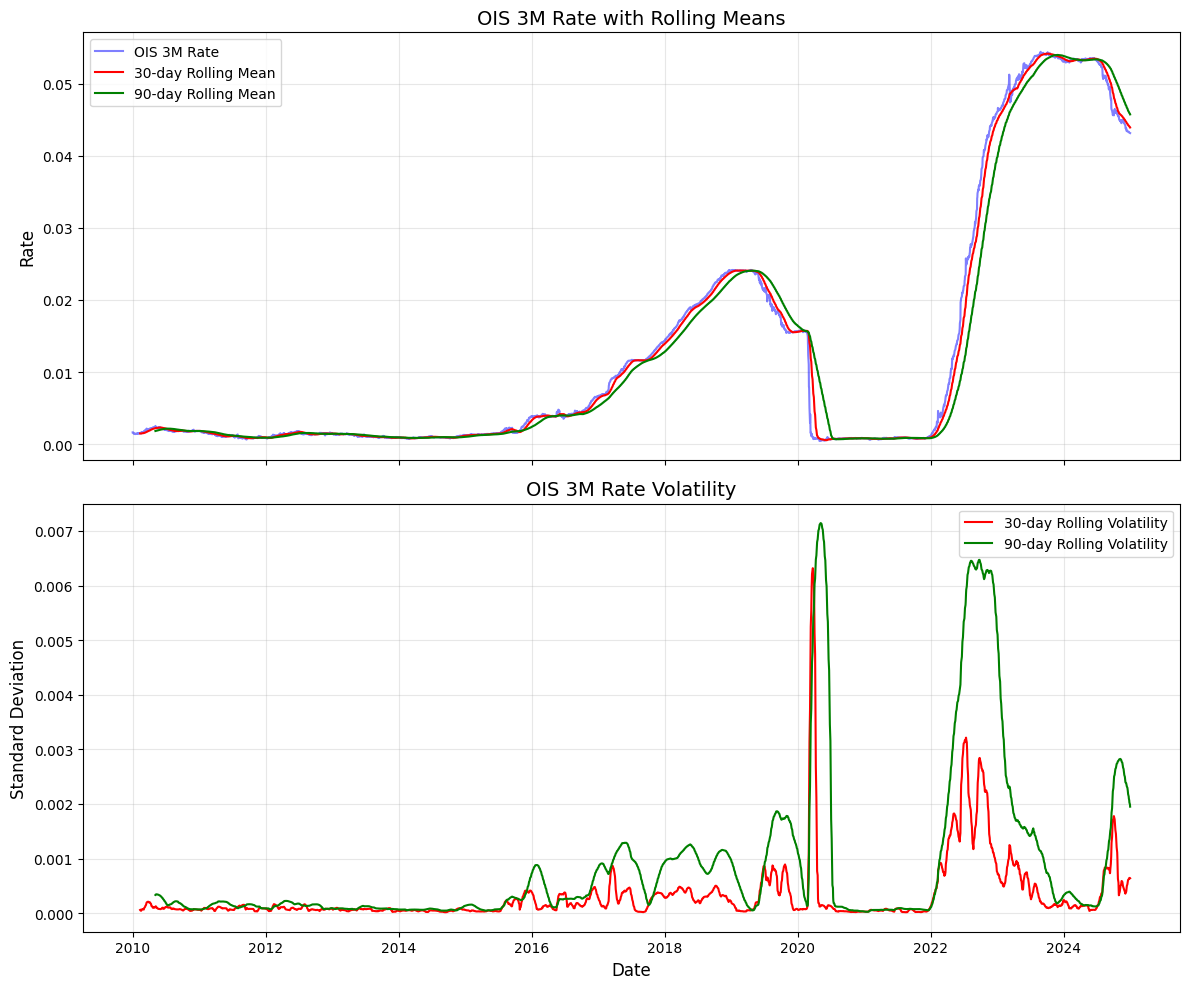

2025-03-07 22:44:12,490 - INFO - Generated rolling statistics and visualizations for the OIS 3M rate


In [12]:
# Calculate 30-day and 90-day rolling means and standard deviations
rolling_mean_30d = ois_df['OIS_3M'].rolling(window=30).mean()
rolling_std_30d = ois_df['OIS_3M'].rolling(window=30).std()
rolling_mean_90d = ois_df['OIS_3M'].rolling(window=90).mean()
rolling_std_90d = ois_df['OIS_3M'].rolling(window=90).std()

# Plot rolling statistics
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot rolling means
axs[0].plot(ois_df.index, ois_df['OIS_3M'], 'b-', alpha=0.5, label='OIS 3M Rate')
axs[0].plot(ois_df.index, rolling_mean_30d, 'r-', label='30-day Rolling Mean')
axs[0].plot(ois_df.index, rolling_mean_90d, 'g-', label='90-day Rolling Mean')
axs[0].set_title('OIS 3M Rate with Rolling Means', fontsize=14)
axs[0].set_ylabel('Rate', fontsize=12)
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Plot rolling standard deviations
axs[1].plot(ois_df.index, rolling_std_30d, 'r-', label='30-day Rolling Volatility')
axs[1].plot(ois_df.index, rolling_std_90d, 'g-', label='90-day Rolling Volatility')
axs[1].set_title('OIS 3M Rate Volatility', fontsize=14)
axs[1].set_xlabel('Date', fontsize=12)
axs[1].set_ylabel('Standard Deviation', fontsize=12)
axs[1].grid(True, alpha=0.3)
axs[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ois_3m_rolling_statistics.png', dpi=300)
plt.show()

# Log the results
logger.info("Generated rolling statistics and visualizations for the OIS 3M rate")

We can visually see that OIS rate has a time varying mean and time varying volatility component. Periods of rate volatility often correspond to wider arbitrage spreads as market participants face uncertainty about funding costs. Thus, visualing the patterns in OIS rates are essential is understanding spreads.


**Post-Financial Crisis Period (2010-2015)**:

Low and stable OIS rates (near zero) reflecting the Federal Reserve's accommodative monetary policy following the 2008-2009 financial crisis. Limited volatility as the Fed maintained its zero interest rate policy (ZIRP)


**Gradual Normalization (2016-2019)**:

Steady increase in OIS rates as the Federal Reserve implemented its policy normalization program. December 2015 marked the first rate hike after nearly a decade at zero. Reduced balance sheet and rising federal funds rate target led to a gradual upward trend in OIS rates


**COVID-19 Pandemic Shock (2020)**:

Sharp spike in volatility in March 2020 corresponding to the global COVID-19 market panic. Dramatic rate cuts by the Federal Reserve returning to near-zero rates. Implementation of extensive quantitative easing and emergency liquidity facilities. This period shows the highest short-term volatility in our dataset


**Inflation Surge and Monetary Tightening (2022-2023)**:

Pronounced upward trend in OIS rates beginning in early 2022. Reflects the Federal Reserve's aggressive rate hiking cycle in response to persistent inflation.OIS rates reached their highest levels in over a decade

**Increasing volatility in rates, but falling levels (2024-2025)**:
The Federal Open Market Committee (FOMC) cut the range by 50 basis points to 4.75 to 5.00 percent in mid-September and by another 25 basis points to 4.50 to 4.75 percent in early November. As expected, yields on short-term Treasury bills fell in kind, with the 3-month yield dropping from 4.87 percent on September 16 to 4.54 percent. [CRFB](https://www.crfb.org/blogs/fed-cuts-rates-treasury-yields-are-rising)

The election day volatility surge could reflect a belief that the election outcome will lead to stronger economic growth, more inflation, additional debt, or some combination of the three. Though

## Unit Tests for OIS Data Processing

Here we perform some sanity checking of the data processing steps performed here, which will be critical prior to the calculation of spreads.

Each unit test in our OIS data processing pipeline serves a specific purpose to ensure data quality and compatibility with downstream analysis. Below is the rationale behind each test:

### Test 1: Check for Non-Empty DataFrame
**Rationale:** An empty DataFrame would cause all subsequent calculations to fail. This basic check ensures we have data to work with before proceeding.

### Test 2: Verify OIS_3M Column Exists
**Rationale:** The entire analysis depends on the 3-month OIS rate. If this column is missing or incorrectly named, all downstream calculations would fail or produce meaningless results.

### Test 3: Confirm Decimal Format Conversion
**Rationale:** The downstream forward rate calculations require OIS rates in decimal format (e.g., 0.0325 rather than 3.25%). Using percentage values would amplify the implied forward rates by 100x, creating dramatically incorrect arbitrage spreads.

### Test 4: Ensure No Missing Values
**Rationale:** Missing OIS values would create gaps in our arbitrage spread calculations. We enforce a clean dataset here to prevent unexplained NaN values later in the analysis pipeline.

### Test 5: Validate Reasonable Rate Range
**Rationale:** OIS rates should be positive (>=0) and realistically below 50% (<0.5 in decimal). Values outside this range likely indicate data errors that would distort our arbitrage analysis.

### Test 6: Verify DatetimeIndex
**Rationale:** The as-of merge in the forward rate calculation requires a DatetimeIndex. This merge operation finds the latest OIS rate available on or before each futures observation date, making proper datetime indexing essential.

### Test 7: Check Data Continuity for merging consistency (10-day threshold)
**Rationale:** The as-of merge requires reasonable continuity in OIS data. We use a 10-day threshold because:
1. Trading days typically occur 5 days per week
2. A 10-day gap represents approximately two weeks of calendar time
3. Longer gaps would mean using significantly outdated OIS rates in the merge
4. The downstream equity arbitrage calculation uses OIS as a benchmark risk-free rate, which becomes unreliable if too stale
5. Since we're using a backward-looking merge, large gaps in OIS data could mean many futures data points would match to the same outdated OIS rate.

### Test 8: Confirm Sorted Index
**Rationale:** The `pd.merge_asof()` function specifically requires sorted time series data. If the index isn't monotonically increasing, the as-of merge will fail or produce incorrect matches.

### Test 9: Verify Date Range Coverage
**Rationale:** We target at least 70% coverage of the specified date range because:
1. Insufficient coverage could bias our arbitrage spread analysis toward certain time periods
2. Most financial analyses require reasonable coverage across market cycles
3. The coverage ratio accounts for weekends and holidays (when markets are closed)
4. Significant gaps could lead to seasonal biases in our arbitrage spread analysis

### Test 10: Validate CSV Output Format
**Rationale:** The forward rate calculation script explicitly loads "cleaned_ois_rates.csv" and expects:
1. A date column (either as 'Date' or as an index in 'Unnamed: 0')
2. An 'OIS_3M' column with the decimal-formatted rates

This test verifies that our output file meets these requirements, ensuring seamless integration with downstream processes.

### As-Of Merge in Downstream Process
The downstream script (`implied_forward_rate.py`) uses the as-of merge to pair OIS rates with futures data. A “backward” search selects the last row in the right DataFrame whose ‘on’ key is less than or equal to the left’s key. This means we effectively try to prevent data leakage by trying to use OIS rates on or prior to the other data date. Despite this we believe that most of the dates will be consistent:


merged_df = pd.merge_asof(
   fut_df, ois_df, on="Date", direction="backward"
)


In [13]:
def process_ois_data(filepath: Path) -> pd.DataFrame:
    """
    Extracts, cleans, and formats only the 3-month OIS rate from Bloomberg historical dataset.

    Args:
        filepath (Path): Path to the parquet file containing multi-index Bloomberg data.

    Returns:
        pd.DataFrame: Cleaned OIS dataset containing only the 3-month OIS rate.

    Raises:
        ValueError: If the required OIS column is missing.
    """
    logger.info(f"Loading OIS data from {filepath}")

    try:
        ois_df = pd.read_parquet(filepath)
    except Exception as e:
        logger.error(f"Error reading parquet file: {e}")
        raise

    logger.info(f"Column levels: {ois_df.columns.names}")

    # Ensure required OIS column is present
    required_col = OIS_TENORS["OIS_3M"]
    if (required_col, "PX_LAST") not in ois_df.columns:
        raise ValueError(f"Missing required OIS column: {required_col}")

    # Select only the required 3-month OIS rate column
    ois_df = ois_df.loc[:, [(required_col, "PX_LAST")]]
    ois_df.columns = ["OIS_3M"]  # Rename to a clean column name

    # Convert OIS rates from percentage to decimal format (if applicable)
    logger.info("Converting OIS_3M from percentage to decimal format")
    ois_df["OIS_3M"] = ois_df["OIS_3M"] / 100

    # Drop rows with missing values
    ois_df = ois_df.dropna(subset=["OIS_3M"])

    # Save the cleaned dataset
    output_path = Path(PROCESSED_DIR) / "cleaned_ois_rates.csv"
    ois_df.to_csv(output_path, index=True)
    logger.info(f"Saved cleaned OIS rates to {output_path}")

    # Log dataset summary
    logger.info("\n========== OIS Data Summary ==========")
    logger.info(f"Shape of dataset: {ois_df.shape} (rows, columns)")
    logger.info(f"Missing values per column:\n{ois_df.isna().sum().to_string()}")
    logger.info("Descriptive statistics:\n%s", ois_df.describe().to_string())
    logger.info("First 5 rows of cleaned OIS data:\n%s", ois_df.head().to_string())

    return ois_df

def test_ois_data_processing(ois_df):
    """Run unit tests for the OIS data processing function."""
    logger.info("Running unit tests for OIS data processing...")
    tests_passed = 0
    tests_failed = 0
    
    # Test 1: Check that dataframe is not empty
    try:
        assert not ois_df.empty, "OIS dataframe should not be empty"
        logger.info("Test 1 Passed: OIS dataframe is not empty")
        tests_passed += 1
    except AssertionError as e:
        logger.error(f"Test 1 Failed: {e}")
        tests_failed += 1
    
    # Test 2: Check that OIS_3M column exists
    try:
        assert "OIS_3M" in ois_df.columns, "OIS_3M column should exist in the dataframe"
        logger.info("Test 2 Passed: OIS_3M column exists")
        tests_passed += 1
    except AssertionError as e:
        logger.error(f"Test 2 Failed: {e}")
        tests_failed += 1
    
    if "OIS_3M" in ois_df.columns and not ois_df.empty:
        # Test 3: Check that OIS rates are converted to decimal format
        try:
            assert all(ois_df['OIS_3M'] < 1.0), "OIS rates should be in decimal format (not percentage)"
            logger.info("Test 3 Passed: OIS rates are in decimal format")
            tests_passed += 1
        except AssertionError as e:
            logger.error(f"Test 3 Failed: {e}")
            tests_failed += 1
        
        # Test 4: Check that there are no missing values
        try:
            assert ois_df['OIS_3M'].isna().sum() == 0, "There should be no missing values in the cleaned data"
            logger.info("Test 4 Passed: No missing values in cleaned data")
            tests_passed += 1
        except AssertionError as e:
            logger.error(f"Test 4 Failed: {e}")
            tests_failed += 1
        
        # Test 5: Check that the OIS rates are within a reasonable range for interest rates
        try:
            assert all(ois_df['OIS_3M'] >= 0), "OIS rates should not be negative"
            assert all(ois_df['OIS_3M'] < 0.5), "OIS rates should be less than 50% (0.5 in decimal)"
            logger.info("Test 5 Passed: OIS rates are within reasonable bounds")
            tests_passed += 1
        except AssertionError as e:
            logger.error(f"Test 5 Failed: {e}")
            tests_failed += 1
    
    # Test 6: Check that the index is a DatetimeIndex for proper as-of merging
    try:
        assert isinstance(ois_df.index, pd.DatetimeIndex), "Index should be a DatetimeIndex"
        logger.info("Test 6 Passed: Index is a DatetimeIndex")
        tests_passed += 1
    except AssertionError as e:
        logger.error(f"Test 6 Failed: {e}")
        tests_failed += 1
    
    # Only continue datetime-specific tests if index is proper
    if isinstance(ois_df.index, pd.DatetimeIndex):
        # Test 7: Check for data continuity (important for as-of merging)
        try:
            # Check if there are no large gaps in the data
            date_diffs = ois_df.index.to_series().diff().dt.days.dropna()
            
            if not date_diffs.empty:
                max_gap = date_diffs.max()
                gap_days_threshold = 10  # Adjust as needed
                assert max_gap <= gap_days_threshold, f"Max gap in OIS data is {max_gap} days, should be ≤ {gap_days_threshold} days"
                logger.info(f"Test 7 Passed: Maximum gap in OIS data is {max_gap} days")
                tests_passed += 1
            else:
                logger.warning("Test 7 Skipped: Insufficient data to check for gaps")
                tests_passed += 0.5  # Partial credit
        except AssertionError as e:
            logger.error(f"Test 7 Failed: {e}")
            tests_failed += 1
        
        # Test 8: Check for sorted index (required for as-of merging)
        try:
            assert ois_df.index.is_monotonic_increasing, "Index must be sorted in ascending order"
            logger.info("Test 8 Passed: Index is properly sorted")
            tests_passed += 1
        except AssertionError as e:
            logger.error(f"Test 8 Failed: {e}")
            tests_failed += 1
        
        # Test 9: Check if index covers required date range
        try:
            start_date = pd.to_datetime(START_DATE)
            end_date = pd.to_datetime(END_DATE)
            
            data_start = ois_df.index.min()
            data_end = ois_df.index.max()
            
            coverage_ratio = len(ois_df) / (end_date - start_date).days
            assert coverage_ratio >= 0.7, f"Date coverage ratio is {coverage_ratio:.2f}, should be ≥ 0.7"
            
            logger.info(f"Test 9 Passed: Data covers from {data_start} to {data_end} with {coverage_ratio:.2f} coverage ratio")
            tests_passed += 1
        except (ImportError, AssertionError) as e:
            logger.error(f"Test 9 Failed: {e}")
            tests_failed += 1
    
    # Test 10: Verify CSV output is correctly formatted
    try:
        output_path = Path(PROCESSED_DIR) / "cleaned_ois_rates.csv"
        assert output_path.exists(), "Output CSV file must exist"
        test_df = pd.read_csv(output_path)
        
        # Check that date column exists (either as 'Date' or index)
        date_col_exists = any(col in ["Date", "Unnamed: 0"] for col in test_df.columns)
        assert date_col_exists, "CSV must have a date column for merging"
        
        # Check that OIS column exists
        assert "OIS_3M" in test_df.columns, "CSV must have OIS_3M column"
        
        logger.info("Test 10 Passed: CSV output is correctly formatted")
        tests_passed += 1
    except (AssertionError, Exception) as e:
        logger.error(f"Test 10 Failed: {e}")
        tests_failed += 1
    
    logger.info(f"Unit tests complete: {tests_passed} passed, {tests_failed} failed")
    return tests_passed, tests_failed

try:
    ois_df = process_ois_data(INPUT_FILE)
    tests_passed, tests_failed = test_ois_data_processing(ois_df)
except Exception as e:
    logger.error(f"Error in processing or testing OIS data: {e}")
    raise

2025-03-07 22:44:12,524 - INFO - Loading OIS data from C:\Users\Andik\OneDrive\Desktop\Chicago\Full_stack_QF\Equity_Spot_futures_arb\data_manual\bloomberg_historical_data.parquet
2025-03-07 22:44:12,544 - INFO - Column levels: [None, None]
2025-03-07 22:44:12,550 - INFO - Converting OIS_3M from percentage to decimal format
2025-03-07 22:44:12,571 - INFO - Saved cleaned OIS rates to C:\Users\Andik\OneDrive\Desktop\Chicago\Full_stack_QF\Equity_Spot_futures_arb\_data\processed\cleaned_ois_rates.csv
2025-03-07 22:44:12,573 - INFO - 
========== OIS Data Summary ==========
2025-03-07 22:44:12,574 - INFO - Shape of dataset: (3894, 1) (rows, columns)
2025-03-07 22:44:12,576 - INFO - Missing values per column:
OIS_3M    0
2025-03-07 22:44:12,583 - INFO - Descriptive statistics:
            OIS_3M
count  3894.000000
mean      0.012734
std       0.017346
min       0.000430
25%       0.001070
50%       0.002130
75%       0.018882
max       0.054432
2025-03-07 22:44:12,586 - INFO - First 5 rows of 

## Integration with Equity Spot-Futures Arbitrage Analysis

Our processed OIS data (stored in `cleaned_ois_rates.csv`) serves as a critical input for the next step in our equity spot-futures arbitrage analysis. Here's how our OIS data processing connects to the broader project:

### How OIS Data Will Be Used

1. **Input for Forward Rate Calculations**: 
   - The subsequent script (`implied_forward_rate.py`) will load our cleaned OIS rates and merge them with futures data
   - The OIS rate serves as the benchmark risk-free rate in all calculations

2. **Calculating Arbitrage Spreads**:
   - The OIS rate will be used to compound dividends
   - It will help calculate the theoretical OIS-implied forward rate
   - The equity spot-futures arbitrage spread (ESF) will be calculated as the difference between:
     * The futures-implied forward rate (derived from futures prices and dividend data)
     * The OIS-implied forward rate (derived from our processed OIS data)

3. **Multi-Index Analysis**:
   - This process will be repeated for three major indices: S&P 500 (SPX), Nasdaq 100 (NDX), and Dow Jones (INDU)
   - The spreads will be analyzed across these indices to identify market inefficiencies

### Expected Outputs

Once our OIS data is integrated with the futures data, we'll generate:

1. Forward rate calculations for each index
2. Filtered arbitrage spread series (with outliers removed)
3. Visualizations comparing spreads across indices
4. Analysis of spread behavior under different market conditions

By properly processing the OIS data now, we ensure accurate measurement of funding cost differentials in the next phase of our equity spot-futures arbitrage project.